In [ ]:
#!pip install transformers[torch]
#!pip install datasets

# Pytoch Approach Training Bert

In [1]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import torch, os
from torch.utils.data import Dataset
import numpy as np

# Loading Data

In [2]:
dataset = load_dataset("trec")


In [12]:
train_df = dataset['train'].to_pandas()
test_df = dataset['test'].to_pandas()

In [13]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

In [14]:
labels = train_df['coarse_label'].unique().tolist()
len(labels)

6

(array([  86.,    0., 1250.,    0., 1162.,    0., 1223.,    0.,  835.,
         896.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

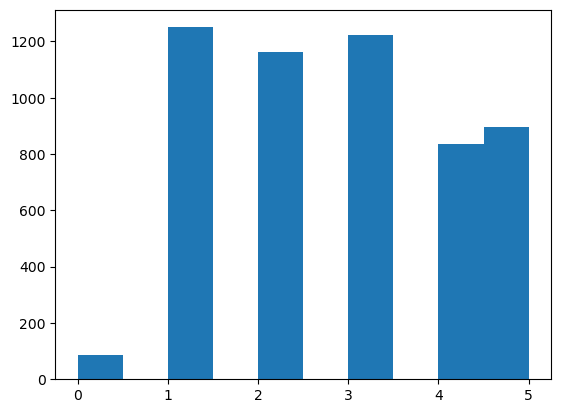

In [15]:
plt.hist(train_df['coarse_label'])


# A Desirable Skewness

In [17]:
train_df['coarse_label'].skew()
test_df['coarse_label'].skew()

0.09677453168815325

# Splitting The Data

In [19]:
SIZE= train_df.shape[0]
print(SIZE)

train_texts= list(train_df.text)
train_labels= list(train_df.coarse_label)

test_texts = list(test_df.text)
test_labels = list(test_df.coarse_label)


5452


In [6]:
from transformers import BertTokenizerFast

In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

# Tokenize the training, test text

In [20]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [21]:
train_texts[0]

'How did serfdom develop in and then leave Russia ?'

In [22]:
from transformers import pipeline, BertForSequenceClassification

# Constucturing Bert Model take in parameter for id2labels and labels2id


In [23]:
id_to_label = {0 : 'ABBR' , 1 : 'ENTY', 2: 'DESC', 3 : 'HUM', 4 : 'LOC', 5 : 'NUM'}
label_to_id= { 'ABBR' : 0 , 'ENTY' : 1, 'DESC': 2, 'HUM' :3, 'LOC' : 4, 'NUM' : 5}


In [24]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(labels), id2label=id_to_label, label2id=label_to_id)


In [25]:
from transformers import TrainingArguments, Trainer

# Constructuring Nessary Parameter For Training Our Model

- Training_args parameter

In [28]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model',
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
)

# Dataloader

 The purpose of this code is to create a custom dataset that can be used for training machine learning models, typically for natural language processing (NLP) tasks like text classification

In [29]:
class DataLoader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        """
          This construct a dict that is (index position) to encoding pairs.
          Where the Encoding becomes tensor(Encoding), which is an requirements
          for training the model
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    
        item['labels'] = torch.tensor(self.labels[idx])
    
    
        return item
    
    def __len__(self):
        """
        Returns the number of data items in the dataset.

        """
        return len(self.labels)


In [30]:
train_dataloader = DataLoader(train_encodings, train_labels)
test_dataloader = DataLoader(test_encodings,test_labels)

In [31]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Construct compute_metrics function

In [32]:
def compute_metrics(pred):

    # Extract true labels from the input object
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro',zero_division=1)

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [33]:
trainer = Trainer(
    #the pre-trained bert model that will be fine-tuned
    model=model,
    #training arguments that we defined above
    args=training_args,
    train_dataset= train_dataloader,
    eval_dataset = test_dataloader,
    compute_metrics= compute_metrics
)

In [34]:
trainer.train()

  0%|          | 0/1023 [00:00<?, ?it/s]

{'loss': 0.1468, 'learning_rate': 2.5e-05, 'epoch': 0.15}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1993018537759781, 'eval_Accuracy': 0.962, 'eval_F1': 0.9490183422545225, 'eval_Precision': 0.9726613875550045, 'eval_Recall': 0.930710565712344, 'eval_runtime': 17.0225, 'eval_samples_per_second': 29.373, 'eval_steps_per_second': 0.94, 'epoch': 0.15}
{'loss': 0.1893, 'learning_rate': 5e-05, 'epoch': 0.29}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.2106318324804306, 'eval_Accuracy': 0.948, 'eval_F1': 0.9394425903375835, 'eval_Precision': 0.962080169433416, 'eval_Recall': 0.9232875893992144, 'eval_runtime': 17.5842, 'eval_samples_per_second': 28.435, 'eval_steps_per_second': 0.91, 'epoch': 0.29}
{'loss': 0.1906, 'learning_rate': 4.7291440953412786e-05, 'epoch': 0.44}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1664099395275116, 'eval_Accuracy': 0.962, 'eval_F1': 0.9506696512681619, 'eval_Precision': 0.9508293309382919, 'eval_Recall': 0.9510330087830345, 'eval_runtime': 17.4769, 'eval_samples_per_second': 28.609, 'eval_steps_per_second': 0.915, 'epoch': 0.44}
{'loss': 0.1975, 'learning_rate': 4.458288190682557e-05, 'epoch': 0.59}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.15666742622852325, 'eval_Accuracy': 0.966, 'eval_F1': 0.9624398317041893, 'eval_Precision': 0.9753536841467666, 'eval_Recall': 0.951766067058228, 'eval_runtime': 17.1736, 'eval_samples_per_second': 29.114, 'eval_steps_per_second': 0.932, 'epoch': 0.59}
{'loss': 0.1918, 'learning_rate': 4.187432286023836e-05, 'epoch': 0.73}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1473730057477951, 'eval_Accuracy': 0.964, 'eval_F1': 0.9589374213489977, 'eval_Precision': 0.969554690919422, 'eval_Recall': 0.9502911408045408, 'eval_runtime': 17.2546, 'eval_samples_per_second': 28.978, 'eval_steps_per_second': 0.927, 'epoch': 0.73}
{'loss': 0.2199, 'learning_rate': 3.916576381365114e-05, 'epoch': 0.88}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.18834838271141052, 'eval_Accuracy': 0.956, 'eval_F1': 0.9521360292009752, 'eval_Precision': 0.9613524449735117, 'eval_Recall': 0.9457312265851101, 'eval_runtime': 17.1576, 'eval_samples_per_second': 29.142, 'eval_steps_per_second': 0.933, 'epoch': 0.88}
{'loss': 0.1371, 'learning_rate': 3.645720476706392e-05, 'epoch': 1.03}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.17748664319515228, 'eval_Accuracy': 0.958, 'eval_F1': 0.9559750915968629, 'eval_Precision': 0.9648581348510437, 'eval_Recall': 0.9483329863225022, 'eval_runtime': 17.3798, 'eval_samples_per_second': 28.769, 'eval_steps_per_second': 0.921, 'epoch': 1.03}
{'loss': 0.0987, 'learning_rate': 3.3748645720476705e-05, 'epoch': 1.17}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.14244167506694794, 'eval_Accuracy': 0.97, 'eval_F1': 0.9650107875345343, 'eval_Precision': 0.9754552177856013, 'eval_Recall': 0.9559084131324136, 'eval_runtime': 17.5555, 'eval_samples_per_second': 28.481, 'eval_steps_per_second': 0.911, 'epoch': 1.17}
{'loss': 0.0717, 'learning_rate': 3.104008667388949e-05, 'epoch': 1.32}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.153800368309021, 'eval_Accuracy': 0.974, 'eval_F1': 0.9689948089015714, 'eval_Precision': 0.9627101009561781, 'eval_Recall': 0.9764362514747961, 'eval_runtime': 17.9744, 'eval_samples_per_second': 27.817, 'eval_steps_per_second': 0.89, 'epoch': 1.32}
{'loss': 0.1025, 'learning_rate': 2.833152762730228e-05, 'epoch': 1.47}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1629030406475067, 'eval_Accuracy': 0.974, 'eval_F1': 0.9606593243606972, 'eval_Precision': 0.9624850233948966, 'eval_Recall': 0.9591254624248765, 'eval_runtime': 17.9874, 'eval_samples_per_second': 27.797, 'eval_steps_per_second': 0.89, 'epoch': 1.47}
{'loss': 0.0913, 'learning_rate': 2.5622968580715063e-05, 'epoch': 1.61}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.175853431224823, 'eval_Accuracy': 0.968, 'eval_F1': 0.9516323635805808, 'eval_Precision': 0.9379869586398645, 'eval_Recall': 0.9716824227154168, 'eval_runtime': 17.3758, 'eval_samples_per_second': 28.776, 'eval_steps_per_second': 0.921, 'epoch': 1.61}
{'loss': 0.0662, 'learning_rate': 2.2914409534127847e-05, 'epoch': 1.76}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.20271524786949158, 'eval_Accuracy': 0.96, 'eval_F1': 0.9473672556778548, 'eval_Precision': 0.9696256630907086, 'eval_Recall': 0.9303248157690719, 'eval_runtime': 17.4549, 'eval_samples_per_second': 28.645, 'eval_steps_per_second': 0.917, 'epoch': 1.76}
{'loss': 0.0496, 'learning_rate': 2.0205850487540627e-05, 'epoch': 1.91}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.21229073405265808, 'eval_Accuracy': 0.962, 'eval_F1': 0.9603001646789565, 'eval_Precision': 0.9732807382490926, 'eval_Recall': 0.9494124613342588, 'eval_runtime': 17.3198, 'eval_samples_per_second': 28.869, 'eval_steps_per_second': 0.924, 'epoch': 1.91}
{'loss': 0.0723, 'learning_rate': 1.7497291440953414e-05, 'epoch': 2.05}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.14698031544685364, 'eval_Accuracy': 0.976, 'eval_F1': 0.9699797508310087, 'eval_Precision': 0.9810445806868482, 'eval_Recall': 0.9603331918934755, 'eval_runtime': 17.3432, 'eval_samples_per_second': 28.83, 'eval_steps_per_second': 0.923, 'epoch': 2.05}
{'loss': 0.0523, 'learning_rate': 1.4788732394366198e-05, 'epoch': 2.2}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.18820185959339142, 'eval_Accuracy': 0.964, 'eval_F1': 0.9607426817630635, 'eval_Precision': 0.9723741551122504, 'eval_Recall': 0.9508873875879461, 'eval_runtime': 17.3411, 'eval_samples_per_second': 28.833, 'eval_steps_per_second': 0.923, 'epoch': 2.2}
{'loss': 0.0269, 'learning_rate': 1.2080173347778981e-05, 'epoch': 2.35}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1586395800113678, 'eval_Accuracy': 0.974, 'eval_F1': 0.960611226546899, 'eval_Precision': 0.962247178466475, 'eval_Recall': 0.9594100259482108, 'eval_runtime': 17.0229, 'eval_samples_per_second': 29.372, 'eval_steps_per_second': 0.94, 'epoch': 2.35}
{'loss': 0.0186, 'learning_rate': 9.371614301191767e-06, 'epoch': 2.49}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1506872922182083, 'eval_Accuracy': 0.976, 'eval_F1': 0.9699797508310087, 'eval_Precision': 0.9810445806868482, 'eval_Recall': 0.9603331918934755, 'eval_runtime': 17.0296, 'eval_samples_per_second': 29.361, 'eval_steps_per_second': 0.94, 'epoch': 2.49}
{'loss': 0.0307, 'learning_rate': 6.6630552546045514e-06, 'epoch': 2.64}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.1508711725473404, 'eval_Accuracy': 0.974, 'eval_F1': 0.9605224772971148, 'eval_Precision': 0.9622136415051802, 'eval_Recall': 0.9591254624248765, 'eval_runtime': 17.724, 'eval_samples_per_second': 28.21, 'eval_steps_per_second': 0.903, 'epoch': 2.64}
{'loss': 0.0117, 'learning_rate': 3.954496208017335e-06, 'epoch': 2.79}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.15717777609825134, 'eval_Accuracy': 0.974, 'eval_F1': 0.9605224772971148, 'eval_Precision': 0.9622136415051802, 'eval_Recall': 0.9591254624248765, 'eval_runtime': 16.9369, 'eval_samples_per_second': 29.521, 'eval_steps_per_second': 0.945, 'epoch': 2.79}
{'loss': 0.0035, 'learning_rate': 1.2459371614301193e-06, 'epoch': 2.93}


  0%|          | 0/16 [00:00<?, ?it/s]

{'eval_loss': 0.156753808259964, 'eval_Accuracy': 0.974, 'eval_F1': 0.9605224772971148, 'eval_Precision': 0.9622136415051802, 'eval_Recall': 0.9591254624248765, 'eval_runtime': 17.048, 'eval_samples_per_second': 29.329, 'eval_steps_per_second': 0.939, 'epoch': 2.93}
{'train_runtime': 3731.9046, 'train_samples_per_second': 4.383, 'train_steps_per_second': 0.274, 'train_loss': 0.09692953582325056, 'epoch': 3.0}


TrainOutput(global_step=1023, training_loss=0.09692953582325056, metrics={'train_runtime': 3731.9046, 'train_samples_per_second': 4.383, 'train_steps_per_second': 0.274, 'train_loss': 0.09692953582325056, 'epoch': 3.0})

Save the model and load it

In [35]:
evaluation_series =[trainer.evaluate(eval_dataset=data) for data in [train_dataloader, test_dataloader]]

  0%|          | 0/171 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [36]:
pd.DataFrame(evaluation_series, index=['train','test'])

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
train,0.007744,0.998533,0.995191,0.996988,0.993440,324.0141,16.826,0.528,3.0
test,0.155612,0.974000,0.960522,0.962214,0.959125,17.8160,28.065,0.898,3.0


In [ ]:
model_path = "bert-base-uncased"

trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('bert-base-uncased/tokenizer_config.json',
 'bert-base-uncased/special_tokens_map.json',
 'bert-base-uncased/vocab.txt',
 'bert-base-uncased/added_tokens.json',
 'bert-base-uncased/tokenizer.json')

In [37]:
model_path = "bert-base-uncased"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

## Predicting the first 15 text

In [38]:
test_df[['text','coarse_label']].iloc[:15]

,text,coarse_label
0,How far is it from Denver to Aspen ?,5
1,"What county is Modesto , California in ?",4
2,Who was Galileo ?,3
3,What is an atom ?,2
4,When did Hawaii become a state ?,5
5,How tall is the Sears Building ?,5
6,George Bush purchased a small interest in whic...,3
7,What is Australia 's national flower ?,1
8,Why does the moon turn orange ?,2
9,What is autism ?,2


In [39]:
def prediction(text):
  input_ids = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
  input_ids = input_ids
  with torch.no_grad():
    outputs = model(**input_ids)
  logits = outputs.logits
  predicted_probabilities = torch.softmax(logits,dim=1)
  predicted_label_id = torch.argmax(predicted_probabilities, dim=1).item()
  predicted_label = id_to_label[predicted_label_id]
  return predicted_label_id


In [40]:
predictions = []
for text in test_texts[:15]:
  predictions.append(prediction(text))

In [41]:
pd.DataFrame( {'pred' : predictions, 'actual' : test_df['coarse_label'][:15] })

,pred,actual
0,5,5
1,4,4
2,3,3
3,2,2
4,5,5
5,5,5
6,3,3
7,1,1
8,2,2
9,2,2


In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

In [45]:

predictions = []
for text in test_texts:
    predictions.append(prediction(text))
    

In [52]:
len(np.array(predictions))

500

In [55]:
def convert_id_to_label(predictions): 
    predictions_in_label =  [] 
    for ID in predictions:
        predictions_in_label.append(id_to_label[ID])
    return predictions_in_label


In [67]:
predictions_in_labels = convert_id_to_label(predictions)
test_labels = convert_id_to_label(test_labels)

## ConfusionMatrixDisplay

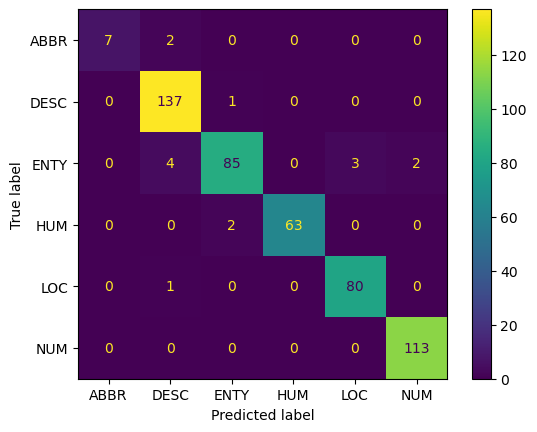

In [69]:
display = ConfusionMatrixDisplay.from_predictions(test_labels,predictions_in_labels)

### Logistic Regression


In [ ]:
df = dataset['train'].to_pandas()

In [ ]:
X = df['text']
y = df[['coarse_label','fine_label']]

### Splitting The Data

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, random_state = 123)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2),min_df=5)
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
len_feature_space = len(tfidf_vectorizer.vocabulary_)

### Constructuring Logistic Regression Model with Hyparameter 'OVR'

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
lr = LogisticRegression(multi_class= 'ovr')
lr.fit(X_train_tfidf, y_train['coarse_label'])

LogisticRegression(multi_class='ovr')

In [ ]:
predictions = lr.predict(X_test_tfidf)

In [ ]:
acc_score = accuracy_score(y_test['coarse_label'], predictions)
acc_score

0.8215158924205379

In [ ]:
series = { 'lr_prediction' : predictions[:15] , 'label' : y_test['coarse_label'][:15] }
predictions_label_df = pd.DataFrame(series)
predictions_label_df


,lr_prediction,label
4539,2,2
1103,3,3
1615,1,2
1186,1,1
4863,1,3
3439,3,3
5359,3,3
920,4,2
1820,5,5
4465,1,1


### ANN

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical

In [ ]:
y_train_one_hot = to_categorical(y_train['coarse_label'], num_classes=6)  # Subtract 1 to convert labels to 0-based indexing
y_train_one_hot.shape

(4634, 6)

In [ ]:
X_train_tfidf,X_test_tfidf

(<4634x1574 sparse matrix of type '<class 'numpy.float64'>'
 	with 39014 stored elements in Compressed Sparse Row format>,
 <818x1574 sparse matrix of type '<class 'numpy.float64'>'
 	with 6508 stored elements in Compressed Sparse Row format>)

In [ ]:
ANN = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(1574,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(6, activation='softmax')
])

# Compile the model
ANN.compile(optimizer='adam',loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
X_train_tfidf_matrix = X_train_tfidf.toarray()
X_test_tfidf_matrix = X_test_tfidf.toarray()


In [ ]:
X_train_tfidf_matrix.shape

(4634, 1574)

In [ ]:
y_train_one_hot.shape

(4634, 6)

In [ ]:
ANN.fit(X_train_tfidf_matrix, y_train_one_hot, epochs=30)


Epoch 1/30
145/145 [==============================] - 3s 5ms/step - loss: 1.2665 - accuracy: 0.5762
Epoch 2/30
145/145 [==============================] - 1s 5ms/step - loss: 0.4300 - accuracy: 0.8666
Epoch 3/30
145/145 [==============================] - 1s 5ms/step - loss: 0.2539 - accuracy: 0.9245
Epoch 4/30
145/145 [==============================] - 1s 6ms/step - loss: 0.1824 - accuracy: 0.9467
Epoch 5/30
145/145 [==============================] - 1s 7ms/step - loss: 0.1439 - accuracy: 0.9558
Epoch 6/30
145/145 [==============================] - 1s 8ms/step - loss: 0.1165 - accuracy: 0.9685
Epoch 7/30
145/145 [==============================] - 1s 8ms/step - loss: 0.1028 - accuracy: 0.9700
Epoch 8/30
145/145 [==============================] - 1s 7ms/step - loss: 0.0910 - accuracy: 0.9743
Epoch 9/30
145/145 [==============================] - 1s 6ms/step - loss: 0.0824 - accuracy: 0.9748
Epoch 10/30
145/145 [==============================] - 1s 5ms/step - loss: 0.0753 - accuracy: 0.9756

In [ ]:
pred_for_testing = lr.predict(X_test_tfidf_matrix)

In [ ]:
pred_actual_series = {'predictions' : pred_for_testing[:15], 'actual' :  y_test['coarse_label'][:15]}

In [ ]:
pd.DataFrame(pred_actual_series)

,predictions,actual
4539,2,2
1103,3,3
1615,1,2
1186,1,1
4863,1,3
3439,3,3
5359,3,3
920,4,2
1820,5,5
4465,1,1
